In [13]:
# 🚀 Auto-setup: installs deps + configures CFBD access
%run ./_auto_setup.py


🔧 Notebook auto-setup complete:
  • Project root: /Users/stephen_bowman/Documents/GitHub/Script_Ohio_2.0
  • Requirements: /Users/stephen_bowman/Documents/GitHub/Script_Ohio_2.0/requirements.txt
  • Missing modules: none
  • Auto install performed: False


# Random Forest: Predicting Home and Away Points

This notebook demonstrates the use of a Random Forest Regressor to predict the final points scored by the home and away teams in college football games.
An **ensemble model** is a type of model that combines multiple individual models to make a final prediction. The idea is that by combining different models, the ensemble can capture a wider range of patterns in the data and make more accurate predictions.

A **Random Forest** is a type of ensemble model that combines and uses many decision trees to make predictions. Each tree is trained on a different subset of the data and makes its own prediction. The Random Forest then averages the predictions of all the trees (for regression tasks) or takes a majority vote (for classification tasks) to make a final prediction. This ensemble approach helps improve the model's accuracy and robustness.


## 1. Load and Prepare Data

In [14]:
import pandas as pd
import sys
from pathlib import Path

# Import configuration system
_config_dir = Path().resolve() / "config"
if str(_config_dir.parent) not in sys.path:
    sys.path.insert(0, str(_config_dir.parent))
from config.data_config import get_data_config

# Get configuration
config = get_data_config()

# Load training data using configuration
training_data_path = config.get_training_data_path()
df = pd.read_csv(training_data_path)

features = ['home_adjusted_success', 'home_adjusted_success_allowed', 'away_adjusted_success', 'away_adjusted_success_allowed',
            'home_adjusted_rushing_epa', 'home_adjusted_rushing_epa_allowed', 'away_adjusted_rushing_epa', 'away_adjusted_rushing_epa_allowed',
            'home_adjusted_passing_epa', 'home_adjusted_passing_epa_allowed', 'away_adjusted_passing_epa', 'away_adjusted_passing_epa_allowed']

df.head()

,id,start_date,season,season_type,week,neutral_site,home_team,home_conference,home_elo,home_talent,...,away_front_seven_havoc_defense,away_db_havoc_defense,home_points_per_opportunity_offense,away_points_per_opportunity_offense,home_points_per_opportunity_defense,away_points_per_opportunity_defense,home_avg_start_offense,home_avg_start_defense,away_avg_start_offense,away_avg_start_defense
0,400876038,2016-12-17 19:00:00,2016,postseason,1,True,UTSA,Conference USA,1374.0,397.64,...,0.101865,0.061693,3.722222,4.301370,3.123288,4.291667,68.0,69.4,71.8,70.8
1,400876039,2016-12-17 20:30:00,2016,postseason,1,True,San Diego State,Mountain West,1666.0,482.31,...,0.128499,0.071247,3.908046,3.760870,3.262295,3.647887,66.4,73.5,64.6,66.1
2,400876040,2016-12-17 22:30:00,2016,postseason,1,True,Toledo,Mid-American,1662.0,460.86,...,0.110778,0.076347,4.073171,3.583333,3.609375,2.842105,71.3,69.1,69.5,72.6
3,400876041,2016-12-18 02:00:00,2016,postseason,1,True,Louisiana,Sun Belt,1315.0,421.37,...,0.139717,0.067504,2.928571,3.658824,3.150685,3.774648,71.1,69.6,72.3,66.4
4,400876042,2016-12-19 19:30:00,2016,postseason,1,True,Tulsa,American Athletic,1650.0,409.17,...,0.090186,0.066313,4.204301,3.121212,3.308642,3.987013,70.0,68.2,70.2,68.0


## 2. Train/Test Split

`train_test_split` is a function from scikit-learn that divides your dataset into two parts: a training set and a testing set. The training set is used to teach your model, while the testing set checks how well your model works on new, unseen data. You can choose how much data goes into each part with the `test_size` setting, and keep the results consistent with `random_state`.

This method is better than splitting game data by season because it mixes games from all seasons into both training and testing sets. If you split only by season, your model might learn patterns that only fit certain years and not others. By mixing seasons, you help the model learn general patterns that work for any season, making your predictions more accurate and reliable.

In [15]:
from sklearn.model_selection import train_test_split

# Remove rows with missing target values
df_clean = df.dropna(subset=['home_points', 'away_points'] + features)

if len(df_clean) == 0:
    raise ValueError("No rows with complete data (features and targets). Check for missing values.")

X = df_clean[features]
y_home = df_clean['home_points']
y_away = df_clean['away_points']

print(f"Using {len(df_clean)} games with complete data (dropped {len(df) - len(df_clean)} rows with missing values)")

X_train, X_test, y_train_home, y_test_home = train_test_split(X, y_home, test_size=0.2, random_state=77)
_, _, y_train_away, y_test_away = train_test_split(X, y_away, test_size=0.2, random_state=77)

Using 4838 games with complete data (dropped 1191 rows with missing values)


**Detailed Explanation:**

- `train_test_split` splits the data into training and testing sets. The `test_size=0.2` means 20% of the data is used for testing, and `random_state=77` ensures reproducibility.
- Since we have two target variables (`home_points` and `away_points`), we call `train_test_split` twice: once for `y_home` and once for `y_away`.
- To ensure the splits for `y_home` and `y_away` align with the same rows in `X`, we use the same `random_state` and input `X` in both calls. This guarantees that the indices for train/test sets are identical for both targets.
- In the second call, we only keep `y_train_away` and `y_test_away` (using `_` for unused outputs), because the split indices are already determined by the first call.

**Summary:**  
Calling `train_test_split` twice with the same `X`, `test_size`, and `random_state` ensures that both `y_home` and `y_away` are split consistently, matching the corresponding rows in `X_train` and `X_test`.

## 3. Train Random Forest Models

### Why Use RandomForestRegressor for Predicting Points?

A **RandomForestRegressor** is a Random Forest model used for predicting numbers (not categories). In football games, we want to predict the final points scored by the home and away teams, which are numbers. RandomForestRegressor is good for this job because:

- It can handle lots of different features (like stats for both teams).
- It works well even if the data is complex or not perfectly organized.
- It reduces errors by averaging predictions from many trees.
- It helps avoid overfitting, which means it won’t just memorize the training data.

### What Does n_estimators Mean?

The **n_estimators** setting tells the model how many decision trees to use in the forest. For example, if `n_estimators=100`, the Random Forest will build 100 trees. More trees can make the model more accurate, but also take more time to train. Usually, using more trees is better, up to a point.

In [16]:
from sklearn.ensemble import RandomForestRegressor

model_home = RandomForestRegressor(n_estimators=100, random_state=77)
model_away = RandomForestRegressor(n_estimators=100, random_state=77)

model_home.fit(X_train, y_train_home)
model_away.fit(X_train, y_train_away)

y_pred_home = model_home.predict(X_test)
y_pred_away = model_away.predict(X_test)

## 4. Evaluate Model Performance

We will use the same evaluation metrics from the previous notebook to assess the model's performance on both home and away points predictions.

It is important that the error magnitudes (MAE, MSE, R²) for home and away points are similar. If one model consistently has much higher error than the other, it means our predictions are less reliable for that side. Balanced errors indicate that the model is learning equally well for both home and away teams, leading to fair and trustworthy predictions for game outcomes.

In [17]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def evaluate(true, pred, label):
    mae = mean_absolute_error(true, pred)
    rmse = mean_squared_error(true, pred)
    r2 = r2_score(true, pred)
    print("{} MAE: {:.2f}".format(label, mae))
    print("{} RMSE: {:.2f}".format(label, rmse))
    print("{} R2: {:.2f}\n".format(label, r2))

evaluate(y_test_home, y_pred_home, "Home Points")
evaluate(y_test_away, y_pred_away, "Away Points")

Home Points MAE: 10.29
Home Points RMSE: 160.56
Home Points R2: 0.11

Away Points MAE: 9.49
Away Points RMSE: 142.08
Away Points R2: 0.18



## 5. Predict Implied Margin

`implied_margin = predicted_away_points - predicted_home_points`

We plot a similar distribution of the implied margin as we did with the actual predicted margin in the previous notebook. This helps us visualize how the model predicts the margin of victory between home and away teams and how close it is to the actual final margin.

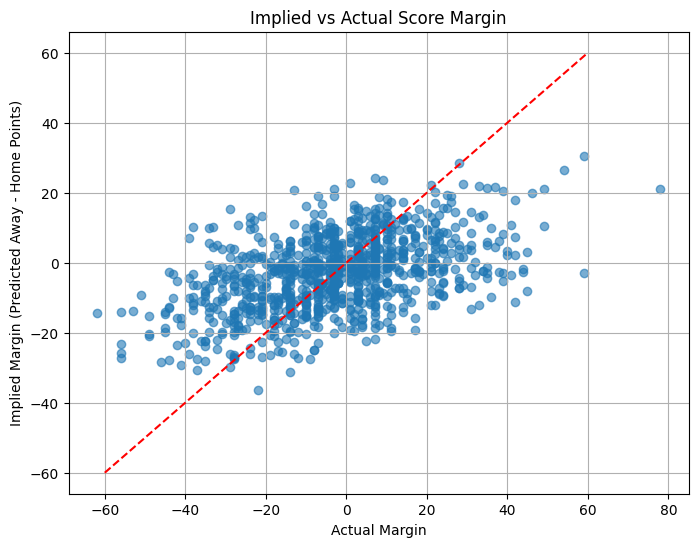

In [18]:
import matplotlib.pyplot as plt

implied_margin = y_pred_away - y_pred_home
actual_margin = y_test_away.values - y_test_home.values

plt.figure(figsize=(8, 6))
plt.scatter(actual_margin, implied_margin, alpha=0.6)
plt.plot([-60, 60], [-60, 60], 'r--')
plt.xlabel("Actual Margin")
plt.ylabel("Implied Margin (Predicted Away - Home Points)")
plt.title("Implied vs Actual Score Margin")
plt.grid(True)
plt.show()

## 6. Save Model

We will save the trained models as before. Note we have two separate models for home and away points, so we will save them with distinct names.

In [19]:
import joblib

joblib.dump(model_home, "random_forest_home.joblib")
joblib.dump(model_away, "random_forest_away.joblib")

['random_forest_away.joblib']

## 7. Next Steps

- **Feature Engineering:** Explore additional features from the dataset to improve model accuracy.
- **Hyperparameter Tuning:** Use grid search or randomized search to optimize Random Forest parameters (e.g., `max_depth`, `min_samples_split`).
- **Interpretability:** Use feature importance plots or SHAP values to understand which features drive predictions.